# EDA
 

## Setup

Create the libraries + import config

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

import sys
sys.path.append('..')

from utils.file_ops import *
from utils.runtime_helpers import *

# get config
CONFIG = read_yaml('../../conf.yaml')

seed_val = 922


Set items based on config

In [3]:
data_dir = '../../data/'

collection_id = CONFIG['COLLECTION_ID']
assets = CONFIG['ASSETS']
crops = CONFIG['CROPS']

selected_bands = [b['id'] for b in CONFIG['BANDS']]
selected_band_names = [b['name'] for b in CONFIG['BANDS']]
source_collection = f'{collection_id}_source'
train_label_collection = f'{collection_id}_labels_train'
test_label_collection = f'{collection_id}_labels_test'

Load the results from our preprocessing steps we created in a prior notebook.

In [4]:
train_data = pd.read_csv(f'{data_dir}pixel_data_TRAIN.csv', index_col=[0])
test_data = pd.read_csv(f'{data_dir}pixel_data_TEST.csv', index_col=[0])
train_labels = pd.read_csv(f'{data_dir}labels_TRAIN.csv', index_col=[0])

train_labels = pd.read_csv(f'{data_dir}labels_TRAIN.csv', index_col=[0])
train_data_agg = pd.read_csv(f'{data_dir}pixel_data_agg_TRAIN.csv', index_col=[0])
test_data_agg = pd.read_csv(f'{data_dir}pixel_data_agg_TEST.csv', index_col=[0])

train_data_and_labels = train_data_agg.merge(train_labels, on=['field_id'])

## EDA

### Field Sizes for Crop Types

In this section we'll explore the sizes of the fields in the AgrifieldNet Competition dataset. First, we group the rows by field id and sort the results.

In [5]:
tmp_train_df = train_data.groupby(by=['field_id']).count().sort_values(by='B01', ascending=False)['B01']
train_pixel_counts_df = pd.DataFrame(tmp_train_df).reset_index()
train_pixel_counts_df.columns = ['field_id', 'pixel_count']
train_pixel_counts_df.head()


,field_id,pixel_count
0,5624,575
1,6170,414
2,5905,387
3,5567,372
4,6044,310


In [6]:
train_pixel_counts_df.tail()


,field_id,pixel_count
5546,6353,1
5547,5573,1
5548,5422,1
5549,3884,1
5550,4082,1


Looking at the results of `head()` and `tail()`, we can see a lot of variance in field sizes. The largest field takes 575 pixels to represent, and smallest areas require only 1 pixel.

Below, we'll add crop names and ids to our rows.

In [7]:
def add_crop_types_to_pixel_field_data(x):
    t = train_labels.loc[train_labels['field_id'] == x.field_id] 
    return pd.Series([
        t.iloc[0]['crop_id'], 
        get_crop_name_from_id(crops, t.iloc[0]['crop_id'])
    ])

train_pixel_counts_df[['crop_id', 'crop_name']] = train_pixel_counts_df.apply(add_crop_types_to_pixel_field_data, axis=1)
train_pixel_counts_df.head()

,field_id,pixel_count,crop_id,crop_name
0,5624,575,2,Mustard
1,6170,414,2,Mustard
2,5905,387,1,Wheat
3,5567,372,1,Wheat
4,6044,310,1,Wheat


While we're here, we'll create a bar plot to see the relative sizes of our fields.

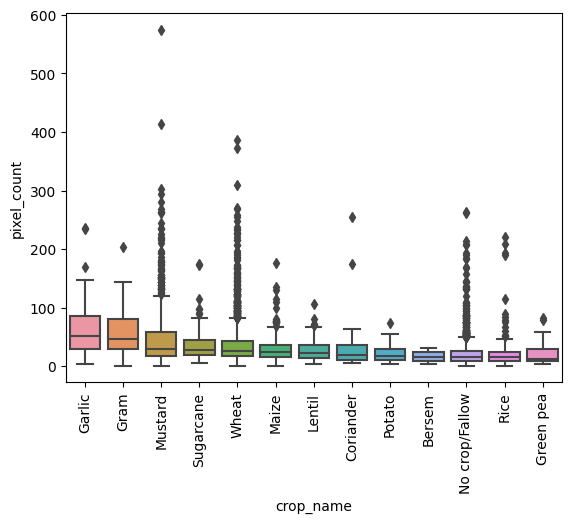

In [8]:
pixel_counts_ordered_by_median = train_pixel_counts_df.groupby(by=['crop_name'])['pixel_count'].median().sort_values(ascending=False)
ax = sns.boxplot(x='crop_name', y='pixel_count', data=train_pixel_counts_df, order=pixel_counts_ordered_by_median.index)
ax.tick_params(axis='x', rotation=90)

The graph above shows a lot of potential outlier values. We will not prune these as they are meaningful for this dataset, but we can file this under 'good to know' as the knowledge that our data has many potential outliers will inform how we process our data and what modeling algorithms we choose. 

Now we're ready to get the median pixel counts by crop type.

*Note: we're calculating the median, as opposed to the mean, as the median is less susceptible to impacts of outliers than the mean.*

In [9]:
median_pixel_counts_by_crop_type = (train_pixel_counts_df
    .groupby(by=['crop_name'])['pixel_count']
    .median()
    .reset_index()
    .sort_values(by='pixel_count'))
median_pixel_counts_by_crop_type

,crop_name,pixel_count
4,Green pea,12.0
0,Bersem,15.0
8,No crop/Fallow,15.0
10,Rice,15.0
9,Potato,18.0
1,Coriander,18.5
5,Lentil,22.0
6,Maize,24.0
12,Wheat,26.0
11,Sugarcane,28.0


Above, we find that Garlic and Gram have the highest median field sizes. On the other end of the spectrum, green peas, bersem, fallow, and rice are associated with smaller fields.

We now know the median field sizes by crop type. Let's obtain field couts by crop type.

In [10]:
field_counts_by_crop_type = train_pixel_counts_df['crop_name'].value_counts().rename_axis('crop_name').reset_index(name='field_count')
field_counts_by_crop_type

,crop_name,field_count
0,Wheat,2031
1,No crop/Fallow,1641
2,Mustard,990
3,Maize,293
4,Sugarcane,163
5,Rice,129
6,Lentil,103
7,Gram,59
8,Garlic,48
9,Potato,41


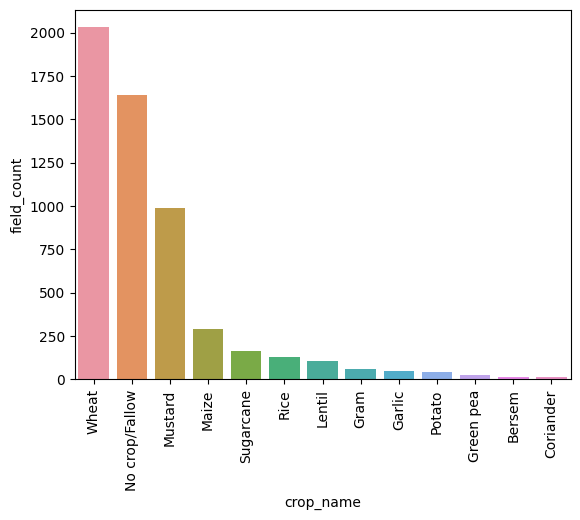

In [11]:
ax = sns.barplot(x='crop_name', y='field_count', data=field_counts_by_crop_type)
ax.tick_params(axis='x', rotation=90)

Above we clearly see the majority of the fields contain wheat, no crop/fallow, and mustard. While gram, garlic, potatoes, green peas, bersem, and coriander combined are planted in just over 200 fields.

### Distribution of Sentinel-2 Band Data

The AgrifieldNet competition page states that the train and test sets have slightly different crop type distributions. It would follow that the Sentinel-2 bands may also have slightly different distributions. Below, we will visualize the distributions of values in each satelitte band for the train and test datasets.

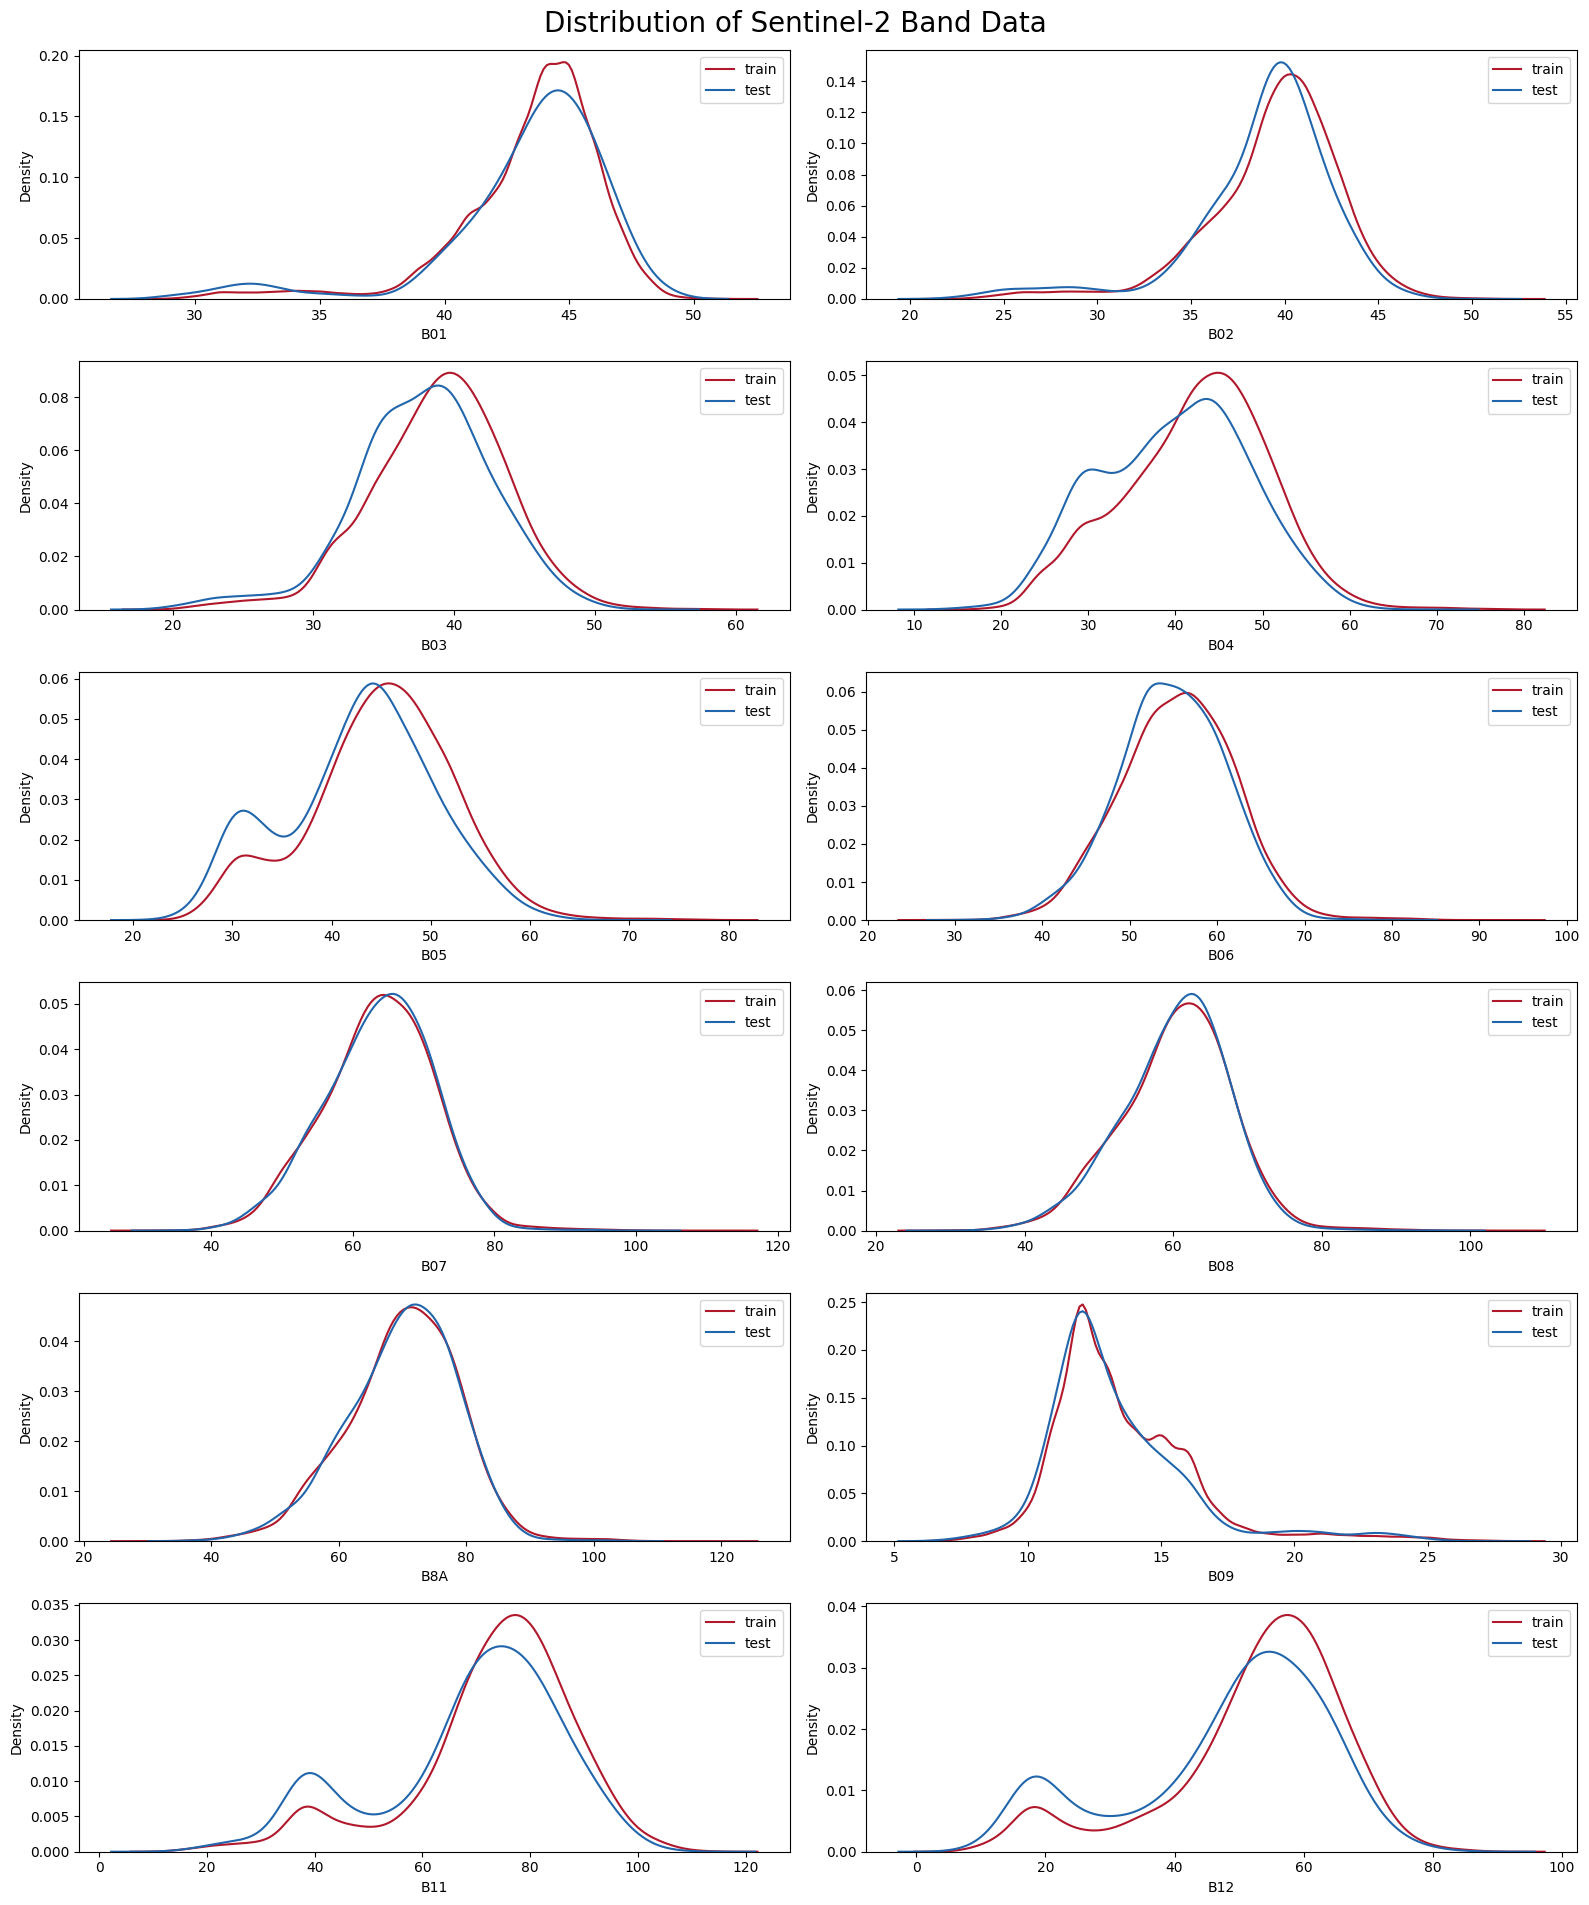

In [20]:
colors = ['#b2182b', '#2166ac']

def plot_dist(train_df, test_df, col, pos):    
    sns.kdeplot(
        train_df[col],
        color = colors[0],
        label='train',
        ax=pos,
        bw_adjust=2)
    sns.kdeplot(
        test_df[col],
        color = colors[1],
        label='test', 
        ax=pos,
        bw_adjust=2)

    pos.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.989])

    return plt

fig, axs = plt.subplots(6,2, figsize=(16,20))
fig.suptitle('Distribution of Sentinel-2 Band Data', fontsize=20)

plot_dist(train_data, test_data, 'B01', axs[0, 0])
plot_dist(train_data, test_data, 'B02', axs[0, 1])
plot_dist(train_data, test_data, 'B03', axs[1, 0])
plot_dist(train_data, test_data, 'B04', axs[1, 1])
plot_dist(train_data, test_data, 'B05', axs[2, 0])
plot_dist(train_data, test_data, 'B06', axs[2, 1])
plot_dist(train_data, test_data, 'B07', axs[3, 0])
plot_dist(train_data, test_data, 'B08', axs[3, 1])
plot_dist(train_data, test_data, 'B8A', axs[4, 0])
plot_dist(train_data, test_data, 'B09', axs[4, 1])
plot_dist(train_data, test_data, 'B11', axs[5, 0])
plot_dist(train_data, test_data, 'B12', axs[5, 1])

plt.show()

## PCA

After adding vegetation indices and computing various summary statistics, we've gone from 12 features to 113. Let's use PCA to attempt to ascertain the predictive value of the features we have while also reducing the dimensionality of our data.

In [14]:
def show_pca(pca, train_data_and_labels, X_train, y_train, selected):
    X = train_data_and_labels.drop(['field_id', 'crop_id'], axis=1)

    plt.figure(figsize=(20,10))
    plt.yticks(fontsize=16)
    sns.scatterplot(x = X_train[:, 0],
                    y = X_train[:, 1],
                    hue = y_train.astype('category'),
                  palette="Spectral")
                
    plt.title("PCA Component 1",font="Serif", size=20,color='k')

    print(pca.explained_variance_ratio_)
    print(get_exp_var_ratio(pca))
    # print('')
    # print(pd.DataFrame(pca.components_, columns=X[selected].columns,index = get_exp_idxs(pca)))

    plt.show()


Here we'll use 3 components for sake of exploration. This number was chosen arbitrarily and, in practice we'd almost certainly generate/utilize more compents for modeling.

[0.29785412 0.22749596 0.133368  ]
0.6587180866372844


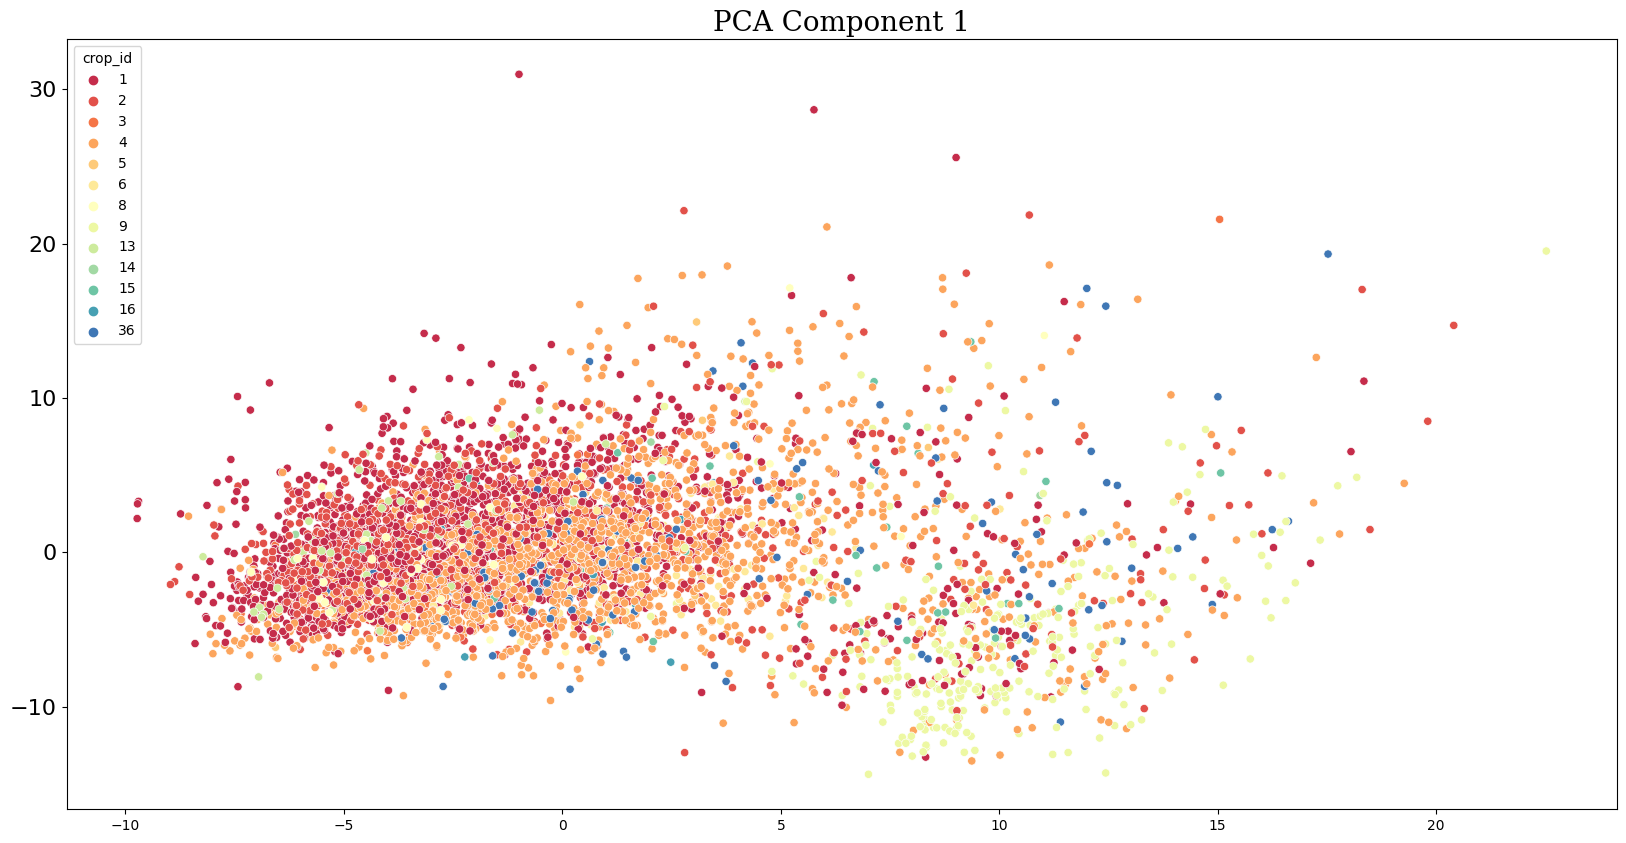

In [15]:
pca_size = 3

X = train_data_and_labels.drop(['field_id', 'crop_id'], axis=1)
y = train_data_and_labels['crop_id'].reset_index()

scaler = RobustScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

pca = PCA(n_components=pca_size) 
X_pca = pca.fit_transform(X_transformed)

show_pca(pca, train_data_and_labels, X_pca, y['crop_id'].astype('category'), X.columns)

The three components generated only account for ~66% of the variance in our data. Let's see what we get when we look at the median values only.

[0.54185969 0.19365335 0.18148839]
0.917001428857051


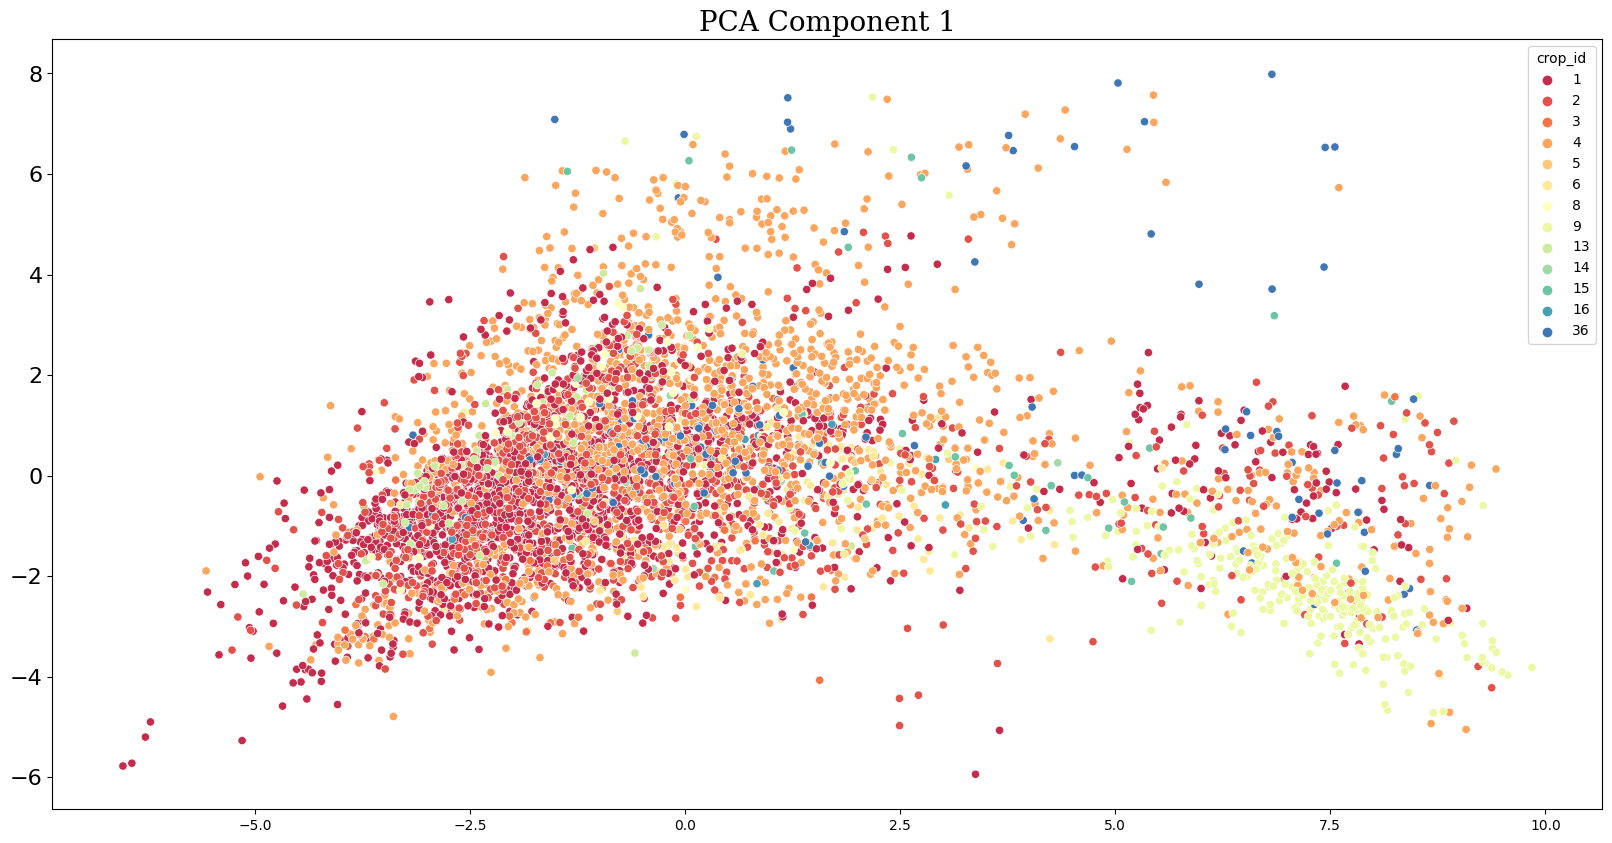

In [16]:
pca_size = 3

agg_idxs = [
    'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12',
    'NDVI', 'ARVI', 'SAVI', 'MSI', 'MCARI', 'MARI', 'EVI2', 'NDMI', 'NDWI',
    'brightness'
]    

agg_metrics = [
    '_median'
]

selected = get_features(agg_idxs, agg_metrics, [])

# Z-score the features
scaler = RobustScaler()
scaler.fit(X[selected])
X_transformed = scaler.transform(X[selected])

pca = PCA(n_components=pca_size) 
X_pca = pca.fit_transform(X_transformed) 

show_pca(pca, train_data_and_labels, X_pca, y['crop_id'].astype('category'), selected)

Using median values only for each feature group improves the performance of the PCA, bringing us up to nearly 92% for 3 components.

## Conclusion and Next steps.

In this notebook we've confirmed that the crops types distribution is skewed and imbalanced, the band data appear to be drawn from _slightly_ different distributions for the train and test sets, and that PCA shows that we can account for a nontrivial amount of variance in the data (a promising finding). 

In the next notebook we will create and tune several models using the data and insights we have gained so far.